In [7]:
import os, math, random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    recall_score, roc_auc_score, mean_absolute_error,
    roc_curve, accuracy_score, precision_score
)
from tqdm import tqdm

import timm
from safetensors.torch import load_file
from adabelief_pytorch import AdaBelief

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
weights_path = os.path.expanduser(
    "~/pscratch/sd/n/natekv/torch/hub/checkpoints/dinov2_vits14_pretrain.safetensors"
)
assert os.path.exists(weights_path), f"Missing weights file: {weights_path}"
print("Found weights:", weights_path)

Found weights: /global/homes/n/natekv/pscratch/sd/n/natekv/torch/hub/checkpoints/dinov2_vits14_pretrain.safetensors


In [13]:
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from safetensors.torch import load_file
from timm.layers.pos_embed import resample_abs_pos_embed

class DinoV2LensRadius(nn.Module):
    def __init__(self, weights_path, in_chans=1, hidden=256, img_size=224):
        super().__init__()

        # Build ViT with fixed img_size=224 (so PatchEmbed assert passes)
        backbone = timm.create_model(
            "vit_small_patch14_dinov2",
            pretrained=False,
            num_classes=0,
            in_chans=3,          # match checkpoint first
            img_size=img_size,
            global_pool="avg",
        )

        # Load local weights
        state = load_file(weights_path)

        # --- Resample absolute pos_embed if needed ---
        if "pos_embed" in state and state["pos_embed"].shape != backbone.pos_embed.shape:
            # grid sizes (exclude class token)
            old_tokens = state["pos_embed"].shape[1] - 1
            new_tokens = backbone.pos_embed.shape[1] - 1
        
            old_g = int(old_tokens ** 0.5)
            new_g = int(new_tokens ** 0.5)
        
            assert old_g * old_g == old_tokens, f"Checkpoint pos tokens not square: {old_tokens}"
            assert new_g * new_g == new_tokens, f"Model pos tokens not square: {new_tokens}"
        
            state["pos_embed"] = resample_abs_pos_embed(
                state["pos_embed"],
                new_size=(new_g, new_g),
                old_size=(old_g, old_g),
                num_prefix_tokens=1,
            )

        missing, unexpected = backbone.load_state_dict(state, strict=False)
        print(f"Loaded weights. missing={len(missing)} unexpected={len(unexpected)}")

        # Convert patch embedding to 1-channel by averaging RGB weights
        old = backbone.patch_embed.proj
        new = nn.Conv2d(
            1, old.out_channels,
            kernel_size=old.kernel_size,
            stride=old.stride,
            padding=old.padding,
            bias=(old.bias is not None),
        )
        with torch.no_grad():
            new.weight.copy_(old.weight.mean(dim=1, keepdim=True))
            if old.bias is not None:
                new.bias.copy_(old.bias)
        backbone.patch_embed.proj = new

        self.backbone = backbone
        feat_dim = backbone.num_features

        self.shared = nn.Sequential(
            nn.Linear(feat_dim, 512), nn.ReLU(True), nn.Dropout(0.2),
            nn.Linear(512, hidden), nn.ReLU(True),
        )
        self.cls_head = nn.Linear(hidden, 1)
        self.rad_head = nn.Linear(hidden, 1)

    def forward(self, x):
        f = self.backbone(x)
        h = self.shared(f)
        lens_logit = self.cls_head(h).squeeze(1)
        theta_pred = F.softplus(self.rad_head(h)).squeeze(1)
        return lens_logit, theta_pred

In [14]:
import numpy as np

path = "/global/cfs/projectdirs/deepsrch/jwst_sims/pristine_bright/"

x0 = np.load(os.path.join(path, "images.npy"))      # expected (N,H,W) or (N,1,H,W)
y_lens = np.load(os.path.join(path, "lensed.npy"))  # (N,) 0/1
theta_e = np.load(os.path.join(path, "theta_Es.npy"))  # (N,) float

print("raw x0:", x0.shape, x0.dtype)
print("raw y_lens:", y_lens.shape, y_lens.dtype, "unique:", np.unique(y_lens)[:10])
print("raw theta_e:", theta_e.shape, theta_e.dtype)

# --- ensure x0 is (N,1,H,W) float32 ---
x0 = x0.astype(np.float32)

if x0.ndim == 3:
    # (N,H,W) -> (N,1,H,W)
    x0 = x0[:, None, :, :]
elif x0.ndim == 4:
    # if channels-last, convert to channels-first
    if x0.shape[-1] == 1:
        x0 = np.transpose(x0, (0, 3, 1, 2))
    # else assume already (N,1,H,W)
else:
    raise ValueError(f"Unexpected x0 shape: {x0.shape}")

# --- normalize globally (you can also do per-image if you want) ---
mean = x0.mean()
std  = x0.std() + 1e-8
x0 = (x0 - mean) / std

# --- ensure labels are right types ---
y_lens = y_lens.astype(np.int64)      # 0/1
theta_e = theta_e.astype(np.float32)  # float

print("processed x0:", x0.shape, x0.dtype, "mean/std:", x0.mean(), x0.std())

raw x0: (20000, 125, 125) float64
raw y_lens: (20000,) float64 unique: [0. 1.]
raw theta_e: (20000,) float64
processed x0: (20000, 1, 125, 125) float32 mean/std: -2.2253926e-07 1.0000141


In [15]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Make sure labels are proper dtypes
y_lens_i = y_lens.astype(np.int64)
theta_e_f = theta_e.astype(np.float32)

class LensRadiusDataset(Dataset):
    def __init__(self, x, y, r):
        self.x = torch.from_numpy(x)          # (N,1,125,125) float32
        self.y = torch.from_numpy(y)          # (N,) int64 (0/1)
        self.r = torch.from_numpy(r)          # (N,) float32

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        x = self.x[idx]  # (1,125,125)
        x = F.interpolate(x.unsqueeze(0), size=(224, 224), mode="bilinear", align_corners=False).squeeze(0)
        return x, self.y[idx], self.r[idx]

idx = np.arange(len(y_lens_i))
train_idx, val_idx = train_test_split(
    idx,
    test_size=0.2,
    stratify=y_lens_i,
    random_state=42
)

r_mean = theta_e_f[train_idx].mean()
r_std  = theta_e_f[train_idx].std() + 1e-8
theta_e_norm = (theta_e_f - r_mean) / r_std

train_ds = LensRadiusDataset(x0[train_idx], y_lens_i[train_idx], theta_e_norm[train_idx])
val_ds   = LensRadiusDataset(x0[val_idx],   y_lens_i[val_idx],   theta_e_norm[val_idx])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

print("train:", len(train_ds), "val:", len(val_ds))
print("train lens fraction:", (y_lens_i[train_idx].mean()))
print("val lens fraction:",   (y_lens_i[val_idx].mean()))

train: 16000 val: 4000
train lens fraction: 0.5
val lens fraction: 0.5


In [16]:
import torch
import torch.nn as nn
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Build model (DINOv2, local weights, no HF) ---
model = DinoV2LensRadius(
    weights_path=weights_path,   # <-- THIS is the key change
    in_chans=1,
    hidden=256
)

# --- DataParallel (only if multiple GPUs available) ---
if torch.cuda.device_count() > 1:
    print("Using DataParallel with", torch.cuda.device_count(), "GPUs")
    model = torch.nn.DataParallel(model)

model = model.to(device)

# --- Class imbalance for lens classification loss ---
counts = Counter(y_lens_i[train_idx].tolist())
n_neg = counts.get(0, 0)
n_pos = counts.get(1, 0)
pos_weight_cls = torch.tensor([n_neg / max(n_pos, 1)], dtype=torch.float32).to(device)

bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight_cls)
reg = nn.SmoothL1Loss()

# --- AdaBelief optimizer ---
from adabelief_pytorch import AdaBelief

optimizer = AdaBelief(
    model.parameters(),
    lr=5e-5,          # good choice for ViT fine-tuning
    eps=1e-8,
    betas=(0.9, 0.999),
    weight_decay=1e-5,
    rectify=True,
    print_change_log=False
)

Loaded weights. missing=2 unexpected=2
Using DataParallel with 4 GPUs
Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


In [17]:
from sklearn.metrics import (
    recall_score, roc_auc_score, mean_absolute_error,
    roc_curve, accuracy_score, precision_score
)
import numpy as np
from tqdm import tqdm
import torch

train_losses, val_losses = [], []
train_accs, val_accs = [], []
val_precisions, val_recalls, val_aucs = [], [], []
val_maes = []  # radius MAE on true lenses only

epochs = 500
patience = 40
best_model_path = "models/dinov2_multi_head.pth"

patience_counter = 0
best_val_auc = -1.0

def unwrap_model(m):
    return m.module if isinstance(m, torch.nn.DataParallel) else m

import os
os.makedirs("models", exist_ok=True)

if os.path.exists(best_model_path):
    unwrap_model(model).load_state_dict(torch.load(best_model_path, map_location=device))
    print("Loaded checkpoint:", best_model_path)
else:
    print("No checkpoint found, training from scratch.")


for epoch in range(epochs):
    # -------------------
    # Train
    # -------------------
    model.train()
    running_loss = 0.0
    correct = 0
    n_total = 0

    # warmup regression
    lambda_reg = 0.0 if epoch < 5 else 0.25

    for x, y, r in tqdm(train_loader, desc=f"[Epoch {epoch+1}] Training"):
        x = x.to(device)           # (B,1,125,125)
        y = y.to(device).float()   # (B,)
        r = r.to(device).float()   # (B,)

        optimizer.zero_grad()

        lens_logit, r_pred = model(x)  # (B,), (B,)

        bce_loss = bce(lens_logit, y)

        mask = (y == 1)
        if mask.any():
            reg_loss = reg(r_pred[mask], r[mask])
        else:
            reg_loss = torch.tensor(0.0, device=device)

        loss = bce_loss + lambda_reg * reg_loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # train metrics (threshold 0.5 is fine just to see progress)
        probs = torch.sigmoid(lens_logit)
        preds = (probs >= 0.5).long()
        correct += (preds == y.long()).sum().item()
        n_total += y.numel()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / max(n_total, 1)

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # -------------------
    # Validate
    # -------------------
    model.eval()
    running_loss = 0.0

    all_probs, all_labels = [], []
    all_r_true, all_r_pred = [], []

    with torch.no_grad():
        for x, y, r in tqdm(val_loader, desc=f"[Epoch {epoch+1}] Validation", leave=False):
            x = x.to(device)
            y = y.to(device).float()
            r = r.to(device).float()

            lens_logit, r_pred = model(x)

            bce_loss = bce(lens_logit, y)

            mask = (y == 1)
            if mask.any():
                reg_loss = reg(r_pred[mask], r[mask])
            else:
                reg_loss = torch.tensor(0.0, device=device)

            loss = bce_loss + lambda_reg * reg_loss
            running_loss += loss.item()

            probs = torch.sigmoid(lens_logit)  # (B,)
            all_probs.extend(probs.detach().cpu().numpy())
            all_labels.extend(y.detach().cpu().numpy().astype(int))

            if mask.any():
                all_r_true.extend(r[mask].detach().cpu().numpy())
                all_r_pred.extend(r_pred[mask].detach().cpu().numpy())

    val_loss = running_loss / len(val_loader)
    probs_np = np.array(all_probs)
    labels_np = np.array(all_labels)

    # --- pick best threshold via Youden J ---
    fpr, tpr, thr = roc_curve(labels_np, probs_np)
    best_t = thr[np.argmax(tpr - fpr)]
    preds_np = (probs_np >= best_t).astype(int)

    val_acc = accuracy_score(labels_np, preds_np)
    val_rec = recall_score(labels_np, preds_np, pos_label=1)
    val_prec = precision_score(labels_np, preds_np, pos_label=1, zero_division=0)

    try:
        val_auc = roc_auc_score(labels_np, probs_np)
    except ValueError:
        val_auc = float("nan")

    pred_pos_rate = float((preds_np == 1).mean())
    true_pos_rate = float((labels_np == 1).mean())

    # --- radius MAE (only y=1), convert back to physical units ---
    if len(all_r_true) > 0:
        r_pred_phys = (np.array(all_r_pred) * r_std) + r_mean
        r_true_phys = (np.array(all_r_true) * r_std) + r_mean
        val_mae = mean_absolute_error(r_true_phys, r_pred_phys)
    else:
        val_mae = float("nan")

    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_precisions.append(val_prec)
    val_recalls.append(val_rec)
    val_aucs.append(val_auc)
    val_maes.append(val_mae)

    print(
        f"[Epoch {epoch+1}] "
        f"Train Loss: {train_loss:.4f}, Acc@0.5: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Acc@t*: {val_acc:.4f}, "
        f"Prec(Lens): {val_prec:.4f}, Recall(Lens): {val_rec:.4f}, "
        f"AUC: {val_auc:.4f}, Radius MAE(y=1): {val_mae:.4f}"
    )
    print(f"Best threshold t*: {best_t:.4f} | Pred lens rate: {pred_pos_rate:.3f} | True lens rate: {true_pos_rate:.3f}")

    # -------------------
    # Early stopping on AUC
    # -------------------
    improved = np.isfinite(val_auc) and (val_auc > best_val_auc + 1e-7)

    if improved:
        best_val_auc = val_auc
        patience_counter = 0
        torch.save(unwrap_model(model).state_dict(), best_model_path)
        print(f"Saved new best model (AUC={val_auc:.4f}) -> {best_model_path}")
    else:
        patience_counter += 1
        print(f"No AUC improvement. Patience: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

No checkpoint found, training from scratch.


[Epoch 1] Training: 100%|██████████| 125/125 [00:19<00:00,  6.34it/s]
                                                                     

[Epoch 1] Train Loss: 0.3625, Acc@0.5: 0.9112 | Val Loss: 0.1643, Acc@t*: 0.9745, Prec(Lens): 0.9867, Recall(Lens): 0.9620, AUC: 0.9928, Radius MAE(y=1): 0.2372
Best threshold t*: 0.7793 | Pred lens rate: 0.487 | True lens rate: 0.500
Saved new best model (AUC=0.9928) -> models/dinov2_multi_head.pth


[Epoch 2] Training: 100%|██████████| 125/125 [00:16<00:00,  7.73it/s]
                                                                     

[Epoch 2] Train Loss: 0.2024, Acc@0.5: 0.9439 | Val Loss: 0.1265, Acc@t*: 0.9742, Prec(Lens): 0.9907, Recall(Lens): 0.9575, AUC: 0.9858, Radius MAE(y=1): 0.2374
Best threshold t*: 0.1823 | Pred lens rate: 0.483 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 3] Training: 100%|██████████| 125/125 [00:16<00:00,  7.70it/s]
                                                                     

[Epoch 3] Train Loss: 0.1709, Acc@0.5: 0.9474 | Val Loss: 0.1040, Acc@t*: 0.9725, Prec(Lens): 0.9763, Recall(Lens): 0.9685, AUC: 0.9933, Radius MAE(y=1): 0.2371
Best threshold t*: 0.3846 | Pred lens rate: 0.496 | True lens rate: 0.500
Saved new best model (AUC=0.9933) -> models/dinov2_multi_head.pth


[Epoch 4] Training: 100%|██████████| 125/125 [00:16<00:00,  7.78it/s]
                                                                     

[Epoch 4] Train Loss: 0.0889, Acc@0.5: 0.9762 | Val Loss: 0.0649, Acc@t*: 0.9818, Prec(Lens): 0.9854, Recall(Lens): 0.9780, AUC: 0.9976, Radius MAE(y=1): 0.2385
Best threshold t*: 0.2763 | Pred lens rate: 0.496 | True lens rate: 0.500
Saved new best model (AUC=0.9976) -> models/dinov2_multi_head.pth


[Epoch 5] Training: 100%|██████████| 125/125 [00:15<00:00,  7.84it/s]
                                                                     

[Epoch 5] Train Loss: 0.0751, Acc@0.5: 0.9791 | Val Loss: 0.0977, Acc@t*: 0.9795, Prec(Lens): 0.9776, Recall(Lens): 0.9815, AUC: 0.9957, Radius MAE(y=1): 0.2413
Best threshold t*: 0.8717 | Pred lens rate: 0.502 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 6] Training: 100%|██████████| 125/125 [00:16<00:00,  7.72it/s]
                                                                     

[Epoch 6] Train Loss: 0.0880, Acc@0.5: 0.9848 | Val Loss: 0.0625, Acc@t*: 0.9895, Prec(Lens): 0.9944, Recall(Lens): 0.9845, AUC: 0.9984, Radius MAE(y=1): 0.1943
Best threshold t*: 0.4432 | Pred lens rate: 0.495 | True lens rate: 0.500
Saved new best model (AUC=0.9984) -> models/dinov2_multi_head.pth


[Epoch 7] Training: 100%|██████████| 125/125 [00:16<00:00,  7.59it/s]
                                                                     

[Epoch 7] Train Loss: 0.0564, Acc@0.5: 0.9901 | Val Loss: 0.0478, Acc@t*: 0.9902, Prec(Lens): 0.9960, Recall(Lens): 0.9845, AUC: 0.9978, Radius MAE(y=1): 0.1127
Best threshold t*: 0.7114 | Pred lens rate: 0.494 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 8] Training: 100%|██████████| 125/125 [00:16<00:00,  7.75it/s]
                                                                     

[Epoch 8] Train Loss: 0.0418, Acc@0.5: 0.9918 | Val Loss: 0.0527, Acc@t*: 0.9878, Prec(Lens): 0.9895, Recall(Lens): 0.9860, AUC: 0.9983, Radius MAE(y=1): 0.0991
Best threshold t*: 0.3997 | Pred lens rate: 0.498 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 9] Training: 100%|██████████| 125/125 [00:15<00:00,  7.86it/s]
                                                                     

[Epoch 9] Train Loss: 0.0447, Acc@0.5: 0.9904 | Val Loss: 0.0412, Acc@t*: 0.9895, Prec(Lens): 0.9934, Recall(Lens): 0.9855, AUC: 0.9989, Radius MAE(y=1): 0.1025
Best threshold t*: 0.3481 | Pred lens rate: 0.496 | True lens rate: 0.500
Saved new best model (AUC=0.9989) -> models/dinov2_multi_head.pth


[Epoch 10] Training: 100%|██████████| 125/125 [00:16<00:00,  7.77it/s]
                                                                      

[Epoch 10] Train Loss: 0.0391, Acc@0.5: 0.9908 | Val Loss: 0.0517, Acc@t*: 0.9890, Prec(Lens): 0.9934, Recall(Lens): 0.9845, AUC: 0.9973, Radius MAE(y=1): 0.0964
Best threshold t*: 0.3194 | Pred lens rate: 0.495 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 11] Training: 100%|██████████| 125/125 [00:16<00:00,  7.61it/s]
                                                                      

[Epoch 11] Train Loss: 0.0371, Acc@0.5: 0.9921 | Val Loss: 0.0311, Acc@t*: 0.9922, Prec(Lens): 0.9930, Recall(Lens): 0.9915, AUC: 0.9994, Radius MAE(y=1): 0.0847
Best threshold t*: 0.2987 | Pred lens rate: 0.499 | True lens rate: 0.500
Saved new best model (AUC=0.9994) -> models/dinov2_multi_head.pth


[Epoch 12] Training: 100%|██████████| 125/125 [00:16<00:00,  7.63it/s]
                                                                      

[Epoch 12] Train Loss: 0.0303, Acc@0.5: 0.9927 | Val Loss: 0.0412, Acc@t*: 0.9910, Prec(Lens): 0.9935, Recall(Lens): 0.9885, AUC: 0.9990, Radius MAE(y=1): 0.0903
Best threshold t*: 0.7743 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 13] Training: 100%|██████████| 125/125 [00:16<00:00,  7.78it/s]
                                                                      

[Epoch 13] Train Loss: 0.0390, Acc@0.5: 0.9899 | Val Loss: 0.0401, Acc@t*: 0.9930, Prec(Lens): 0.9940, Recall(Lens): 0.9920, AUC: 0.9995, Radius MAE(y=1): 0.0765
Best threshold t*: 0.9103 | Pred lens rate: 0.499 | True lens rate: 0.500
Saved new best model (AUC=0.9995) -> models/dinov2_multi_head.pth


[Epoch 14] Training: 100%|██████████| 125/125 [00:16<00:00,  7.80it/s]
                                                                      

[Epoch 14] Train Loss: 0.0289, Acc@0.5: 0.9936 | Val Loss: 0.0295, Acc@t*: 0.9935, Prec(Lens): 0.9965, Recall(Lens): 0.9905, AUC: 0.9995, Radius MAE(y=1): 0.0923
Best threshold t*: 0.4203 | Pred lens rate: 0.497 | True lens rate: 0.500
Saved new best model (AUC=0.9995) -> models/dinov2_multi_head.pth


[Epoch 15] Training: 100%|██████████| 125/125 [00:16<00:00,  7.72it/s]
                                                                      

[Epoch 15] Train Loss: 0.0213, Acc@0.5: 0.9946 | Val Loss: 0.0388, Acc@t*: 0.9912, Prec(Lens): 0.9930, Recall(Lens): 0.9895, AUC: 0.9988, Radius MAE(y=1): 0.0714
Best threshold t*: 0.5806 | Pred lens rate: 0.498 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 16] Training: 100%|██████████| 125/125 [00:15<00:00,  7.85it/s]
                                                                      

[Epoch 16] Train Loss: 0.0195, Acc@0.5: 0.9958 | Val Loss: 0.0361, Acc@t*: 0.9938, Prec(Lens): 0.9970, Recall(Lens): 0.9905, AUC: 0.9995, Radius MAE(y=1): 0.0759
Best threshold t*: 0.9592 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 17] Training: 100%|██████████| 125/125 [00:16<00:00,  7.77it/s]
                                                                      

[Epoch 17] Train Loss: 0.0850, Acc@0.5: 0.9759 | Val Loss: 0.0556, Acc@t*: 0.9860, Prec(Lens): 0.9855, Recall(Lens): 0.9865, AUC: 0.9977, Radius MAE(y=1): 0.0945
Best threshold t*: 0.3181 | Pred lens rate: 0.500 | True lens rate: 0.500
No AUC improvement. Patience: 3/40


[Epoch 18] Training: 100%|██████████| 125/125 [00:15<00:00,  7.86it/s]
                                                                      

[Epoch 18] Train Loss: 0.0426, Acc@0.5: 0.9889 | Val Loss: 0.0493, Acc@t*: 0.9885, Prec(Lens): 0.9934, Recall(Lens): 0.9835, AUC: 0.9990, Radius MAE(y=1): 0.0763
Best threshold t*: 0.9124 | Pred lens rate: 0.495 | True lens rate: 0.500
No AUC improvement. Patience: 4/40


[Epoch 19] Training: 100%|██████████| 125/125 [00:16<00:00,  7.72it/s]
                                                                      

[Epoch 19] Train Loss: 0.0279, Acc@0.5: 0.9931 | Val Loss: 0.0299, Acc@t*: 0.9925, Prec(Lens): 0.9955, Recall(Lens): 0.9895, AUC: 0.9997, Radius MAE(y=1): 0.0877
Best threshold t*: 0.6801 | Pred lens rate: 0.497 | True lens rate: 0.500
Saved new best model (AUC=0.9997) -> models/dinov2_multi_head.pth


[Epoch 20] Training: 100%|██████████| 125/125 [00:16<00:00,  7.78it/s]
                                                                      

[Epoch 20] Train Loss: 0.0225, Acc@0.5: 0.9946 | Val Loss: 0.0353, Acc@t*: 0.9912, Prec(Lens): 0.9980, Recall(Lens): 0.9845, AUC: 0.9993, Radius MAE(y=1): 0.0682
Best threshold t*: 0.8635 | Pred lens rate: 0.493 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 21] Training: 100%|██████████| 125/125 [00:16<00:00,  7.69it/s]
                                                                      

[Epoch 21] Train Loss: 0.0182, Acc@0.5: 0.9959 | Val Loss: 0.0268, Acc@t*: 0.9950, Prec(Lens): 0.9975, Recall(Lens): 0.9925, AUC: 0.9997, Radius MAE(y=1): 0.0663
Best threshold t*: 0.9220 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 22] Training: 100%|██████████| 125/125 [00:16<00:00,  7.68it/s]
                                                                      

[Epoch 22] Train Loss: 0.0132, Acc@0.5: 0.9974 | Val Loss: 0.0271, Acc@t*: 0.9945, Prec(Lens): 0.9980, Recall(Lens): 0.9910, AUC: 0.9996, Radius MAE(y=1): 0.0596
Best threshold t*: 0.5378 | Pred lens rate: 0.496 | True lens rate: 0.500
No AUC improvement. Patience: 3/40


[Epoch 23] Training: 100%|██████████| 125/125 [00:16<00:00,  7.80it/s]
                                                                      

[Epoch 23] Train Loss: 0.0119, Acc@0.5: 0.9977 | Val Loss: 0.0293, Acc@t*: 0.9930, Prec(Lens): 0.9965, Recall(Lens): 0.9895, AUC: 0.9988, Radius MAE(y=1): 0.0669
Best threshold t*: 0.4061 | Pred lens rate: 0.496 | True lens rate: 0.500
No AUC improvement. Patience: 4/40


[Epoch 24] Training: 100%|██████████| 125/125 [00:15<00:00,  7.88it/s]
                                                                      

[Epoch 24] Train Loss: 0.0136, Acc@0.5: 0.9967 | Val Loss: 0.0338, Acc@t*: 0.9938, Prec(Lens): 0.9975, Recall(Lens): 0.9900, AUC: 0.9987, Radius MAE(y=1): 0.0588
Best threshold t*: 0.2143 | Pred lens rate: 0.496 | True lens rate: 0.500
No AUC improvement. Patience: 5/40


[Epoch 25] Training: 100%|██████████| 125/125 [00:15<00:00,  7.83it/s]
                                                                      

[Epoch 25] Train Loss: 0.0154, Acc@0.5: 0.9971 | Val Loss: 0.0294, Acc@t*: 0.9942, Prec(Lens): 0.9960, Recall(Lens): 0.9925, AUC: 0.9992, Radius MAE(y=1): 0.0656
Best threshold t*: 0.6340 | Pred lens rate: 0.498 | True lens rate: 0.500
No AUC improvement. Patience: 6/40


[Epoch 26] Training: 100%|██████████| 125/125 [00:16<00:00,  7.69it/s]
                                                                      

[Epoch 26] Train Loss: 0.0153, Acc@0.5: 0.9962 | Val Loss: 0.0242, Acc@t*: 0.9945, Prec(Lens): 0.9960, Recall(Lens): 0.9930, AUC: 0.9994, Radius MAE(y=1): 0.0571
Best threshold t*: 0.1952 | Pred lens rate: 0.498 | True lens rate: 0.500
No AUC improvement. Patience: 7/40


[Epoch 27] Training: 100%|██████████| 125/125 [00:16<00:00,  7.75it/s]
                                                                      

[Epoch 27] Train Loss: 0.0107, Acc@0.5: 0.9980 | Val Loss: 0.0321, Acc@t*: 0.9935, Prec(Lens): 0.9920, Recall(Lens): 0.9950, AUC: 0.9996, Radius MAE(y=1): 0.0526
Best threshold t*: 0.0173 | Pred lens rate: 0.501 | True lens rate: 0.500
No AUC improvement. Patience: 8/40


[Epoch 28] Training: 100%|██████████| 125/125 [00:15<00:00,  7.88it/s]
                                                                      

[Epoch 28] Train Loss: 0.0102, Acc@0.5: 0.9976 | Val Loss: 0.0377, Acc@t*: 0.9928, Prec(Lens): 0.9980, Recall(Lens): 0.9875, AUC: 0.9982, Radius MAE(y=1): 0.0579
Best threshold t*: 0.4736 | Pred lens rate: 0.495 | True lens rate: 0.500
No AUC improvement. Patience: 9/40


[Epoch 29] Training: 100%|██████████| 125/125 [00:16<00:00,  7.77it/s]
                                                                      

[Epoch 29] Train Loss: 0.0102, Acc@0.5: 0.9981 | Val Loss: 0.0225, Acc@t*: 0.9955, Prec(Lens): 0.9985, Recall(Lens): 0.9925, AUC: 0.9997, Radius MAE(y=1): 0.0583
Best threshold t*: 0.4388 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 10/40


[Epoch 30] Training: 100%|██████████| 125/125 [00:15<00:00,  7.82it/s]
                                                                      

[Epoch 30] Train Loss: 0.0182, Acc@0.5: 0.9963 | Val Loss: 0.0274, Acc@t*: 0.9940, Prec(Lens): 0.9970, Recall(Lens): 0.9910, AUC: 0.9996, Radius MAE(y=1): 0.0586
Best threshold t*: 0.4982 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 11/40


[Epoch 31] Training: 100%|██████████| 125/125 [00:15<00:00,  7.84it/s]
                                                                      

[Epoch 31] Train Loss: 0.0894, Acc@0.5: 0.9741 | Val Loss: 0.0936, Acc@t*: 0.9798, Prec(Lens): 0.9943, Recall(Lens): 0.9650, AUC: 0.9956, Radius MAE(y=1): 0.1132
Best threshold t*: 0.3094 | Pred lens rate: 0.485 | True lens rate: 0.500
No AUC improvement. Patience: 12/40


[Epoch 32] Training: 100%|██████████| 125/125 [00:15<00:00,  7.89it/s]
                                                                      

[Epoch 32] Train Loss: 0.0675, Acc@0.5: 0.9825 | Val Loss: 0.0514, Acc@t*: 0.9860, Prec(Lens): 0.9884, Recall(Lens): 0.9835, AUC: 0.9980, Radius MAE(y=1): 0.0852
Best threshold t*: 0.4285 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 13/40


[Epoch 33] Training: 100%|██████████| 125/125 [00:16<00:00,  7.76it/s]
                                                                      

[Epoch 33] Train Loss: 0.0288, Acc@0.5: 0.9930 | Val Loss: 0.0361, Acc@t*: 0.9922, Prec(Lens): 0.9975, Recall(Lens): 0.9870, AUC: 0.9988, Radius MAE(y=1): 0.0731
Best threshold t*: 0.4646 | Pred lens rate: 0.495 | True lens rate: 0.500
No AUC improvement. Patience: 14/40


[Epoch 34] Training: 100%|██████████| 125/125 [00:16<00:00,  7.79it/s]
                                                                      

[Epoch 34] Train Loss: 0.0206, Acc@0.5: 0.9948 | Val Loss: 0.0321, Acc@t*: 0.9930, Prec(Lens): 0.9975, Recall(Lens): 0.9885, AUC: 0.9989, Radius MAE(y=1): 0.0602
Best threshold t*: 0.6573 | Pred lens rate: 0.495 | True lens rate: 0.500
No AUC improvement. Patience: 15/40


[Epoch 35] Training: 100%|██████████| 125/125 [00:16<00:00,  7.73it/s]
                                                                      

[Epoch 35] Train Loss: 0.0161, Acc@0.5: 0.9961 | Val Loss: 0.0370, Acc@t*: 0.9892, Prec(Lens): 0.9975, Recall(Lens): 0.9810, AUC: 0.9993, Radius MAE(y=1): 0.0643
Best threshold t*: 0.8994 | Pred lens rate: 0.492 | True lens rate: 0.500
No AUC improvement. Patience: 16/40


[Epoch 36] Training: 100%|██████████| 125/125 [00:16<00:00,  7.61it/s]
                                                                      

[Epoch 36] Train Loss: 0.0140, Acc@0.5: 0.9966 | Val Loss: 0.0189, Acc@t*: 0.9955, Prec(Lens): 0.9985, Recall(Lens): 0.9925, AUC: 0.9999, Radius MAE(y=1): 0.0648
Best threshold t*: 0.8322 | Pred lens rate: 0.497 | True lens rate: 0.500
Saved new best model (AUC=0.9999) -> models/dinov2_multi_head.pth


[Epoch 37] Training: 100%|██████████| 125/125 [00:16<00:00,  7.78it/s]
                                                                      

[Epoch 37] Train Loss: 0.0095, Acc@0.5: 0.9983 | Val Loss: 0.0269, Acc@t*: 0.9932, Prec(Lens): 0.9970, Recall(Lens): 0.9895, AUC: 0.9997, Radius MAE(y=1): 0.0589
Best threshold t*: 0.8804 | Pred lens rate: 0.496 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 38] Training: 100%|██████████| 125/125 [00:15<00:00,  7.83it/s]
                                                                      

[Epoch 38] Train Loss: 0.0102, Acc@0.5: 0.9977 | Val Loss: 0.0263, Acc@t*: 0.9942, Prec(Lens): 0.9970, Recall(Lens): 0.9915, AUC: 0.9998, Radius MAE(y=1): 0.0608
Best threshold t*: 0.2909 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 39] Training: 100%|██████████| 125/125 [00:16<00:00,  7.72it/s]
                                                                      

[Epoch 39] Train Loss: 0.0103, Acc@0.5: 0.9977 | Val Loss: 0.0305, Acc@t*: 0.9925, Prec(Lens): 0.9940, Recall(Lens): 0.9910, AUC: 0.9994, Radius MAE(y=1): 0.0636
Best threshold t*: 0.4648 | Pred lens rate: 0.498 | True lens rate: 0.500
No AUC improvement. Patience: 3/40


[Epoch 40] Training: 100%|██████████| 125/125 [00:16<00:00,  7.71it/s]
                                                                      

[Epoch 40] Train Loss: 0.0097, Acc@0.5: 0.9981 | Val Loss: 0.0171, Acc@t*: 0.9960, Prec(Lens): 0.9965, Recall(Lens): 0.9955, AUC: 0.9999, Radius MAE(y=1): 0.0536
Best threshold t*: 0.3346 | Pred lens rate: 0.499 | True lens rate: 0.500
Saved new best model (AUC=0.9999) -> models/dinov2_multi_head.pth


[Epoch 41] Training: 100%|██████████| 125/125 [00:16<00:00,  7.81it/s]
                                                                      

[Epoch 41] Train Loss: 0.0069, Acc@0.5: 0.9989 | Val Loss: 0.0341, Acc@t*: 0.9930, Prec(Lens): 0.9940, Recall(Lens): 0.9920, AUC: 0.9994, Radius MAE(y=1): 0.0577
Best threshold t*: 0.7416 | Pred lens rate: 0.499 | True lens rate: 0.500
No AUC improvement. Patience: 1/40


[Epoch 42] Training: 100%|██████████| 125/125 [00:16<00:00,  7.81it/s]
                                                                      

[Epoch 42] Train Loss: 0.0058, Acc@0.5: 0.9991 | Val Loss: 0.0217, Acc@t*: 0.9945, Prec(Lens): 0.9995, Recall(Lens): 0.9895, AUC: 0.9997, Radius MAE(y=1): 0.0496
Best threshold t*: 0.8759 | Pred lens rate: 0.495 | True lens rate: 0.500
No AUC improvement. Patience: 2/40


[Epoch 43] Training: 100%|██████████| 125/125 [00:16<00:00,  7.81it/s]
                                                                      

[Epoch 43] Train Loss: 0.0070, Acc@0.5: 0.9988 | Val Loss: 0.0249, Acc@t*: 0.9955, Prec(Lens): 0.9980, Recall(Lens): 0.9930, AUC: 0.9996, Radius MAE(y=1): 0.0537
Best threshold t*: 0.4934 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 3/40


[Epoch 44] Training: 100%|██████████| 125/125 [00:16<00:00,  7.75it/s]
                                                                      

[Epoch 44] Train Loss: 0.0044, Acc@0.5: 0.9995 | Val Loss: 0.0251, Acc@t*: 0.9952, Prec(Lens): 0.9980, Recall(Lens): 0.9925, AUC: 0.9995, Radius MAE(y=1): 0.0494
Best threshold t*: 0.3615 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 4/40


[Epoch 45] Training: 100%|██████████| 125/125 [00:15<00:00,  7.88it/s]
                                                                      

[Epoch 45] Train Loss: 0.0081, Acc@0.5: 0.9986 | Val Loss: 0.0332, Acc@t*: 0.9945, Prec(Lens): 0.9950, Recall(Lens): 0.9940, AUC: 0.9995, Radius MAE(y=1): 0.0647
Best threshold t*: 0.9013 | Pred lens rate: 0.499 | True lens rate: 0.500
No AUC improvement. Patience: 5/40


[Epoch 46] Training: 100%|██████████| 125/125 [00:15<00:00,  7.84it/s]
                                                                      

[Epoch 46] Train Loss: 0.0108, Acc@0.5: 0.9980 | Val Loss: 0.0248, Acc@t*: 0.9942, Prec(Lens): 0.9985, Recall(Lens): 0.9900, AUC: 0.9997, Radius MAE(y=1): 0.0521
Best threshold t*: 0.8273 | Pred lens rate: 0.496 | True lens rate: 0.500
No AUC improvement. Patience: 6/40


[Epoch 47] Training: 100%|██████████| 125/125 [00:15<00:00,  7.81it/s]
                                                                      

[Epoch 47] Train Loss: 0.0056, Acc@0.5: 0.9989 | Val Loss: 0.0201, Acc@t*: 0.9960, Prec(Lens): 0.9985, Recall(Lens): 0.9935, AUC: 0.9999, Radius MAE(y=1): 0.0485
Best threshold t*: 0.8451 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 7/40


[Epoch 48] Training: 100%|██████████| 125/125 [00:15<00:00,  7.83it/s]
                                                                      

[Epoch 48] Train Loss: 0.0033, Acc@0.5: 0.9996 | Val Loss: 0.0268, Acc@t*: 0.9940, Prec(Lens): 0.9965, Recall(Lens): 0.9915, AUC: 0.9998, Radius MAE(y=1): 0.0462
Best threshold t*: 0.3426 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 8/40


[Epoch 49] Training: 100%|██████████| 125/125 [00:16<00:00,  7.80it/s]
                                                                      

[Epoch 49] Train Loss: 0.0141, Acc@0.5: 0.9968 | Val Loss: 0.0287, Acc@t*: 0.9930, Prec(Lens): 0.9965, Recall(Lens): 0.9895, AUC: 0.9995, Radius MAE(y=1): 0.0693
Best threshold t*: 0.7076 | Pred lens rate: 0.496 | True lens rate: 0.500
No AUC improvement. Patience: 9/40


[Epoch 50] Training: 100%|██████████| 125/125 [00:15<00:00,  7.82it/s]
                                                                      

[Epoch 50] Train Loss: 0.0066, Acc@0.5: 0.9987 | Val Loss: 0.0229, Acc@t*: 0.9950, Prec(Lens): 0.9975, Recall(Lens): 0.9925, AUC: 0.9995, Radius MAE(y=1): 0.0561
Best threshold t*: 0.4278 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 10/40


[Epoch 51] Training: 100%|██████████| 125/125 [00:15<00:00,  7.82it/s]
                                                                      

[Epoch 51] Train Loss: 0.0081, Acc@0.5: 0.9983 | Val Loss: 0.0287, Acc@t*: 0.9948, Prec(Lens): 0.9975, Recall(Lens): 0.9920, AUC: 0.9993, Radius MAE(y=1): 0.0553
Best threshold t*: 0.5295 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 11/40


[Epoch 52] Training: 100%|██████████| 125/125 [00:16<00:00,  7.48it/s]
                                                                      

[Epoch 52] Train Loss: 0.0075, Acc@0.5: 0.9986 | Val Loss: 0.0272, Acc@t*: 0.9942, Prec(Lens): 0.9970, Recall(Lens): 0.9915, AUC: 0.9995, Radius MAE(y=1): 0.0528
Best threshold t*: 0.3968 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 12/40


[Epoch 53] Training: 100%|██████████| 125/125 [00:16<00:00,  7.75it/s]
                                                                      

[Epoch 53] Train Loss: 0.0061, Acc@0.5: 0.9988 | Val Loss: 0.0285, Acc@t*: 0.9940, Prec(Lens): 0.9985, Recall(Lens): 0.9895, AUC: 0.9995, Radius MAE(y=1): 0.0490
Best threshold t*: 0.7504 | Pred lens rate: 0.495 | True lens rate: 0.500
No AUC improvement. Patience: 13/40


[Epoch 54] Training: 100%|██████████| 125/125 [00:16<00:00,  7.78it/s]
                                                                      

[Epoch 54] Train Loss: 0.0089, Acc@0.5: 0.9981 | Val Loss: 0.0316, Acc@t*: 0.9935, Prec(Lens): 0.9975, Recall(Lens): 0.9895, AUC: 0.9993, Radius MAE(y=1): 0.0482
Best threshold t*: 0.7375 | Pred lens rate: 0.496 | True lens rate: 0.500
No AUC improvement. Patience: 14/40


[Epoch 55] Training: 100%|██████████| 125/125 [00:16<00:00,  7.75it/s]
                                                                      

[Epoch 55] Train Loss: 0.0070, Acc@0.5: 0.9986 | Val Loss: 0.0343, Acc@t*: 0.9935, Prec(Lens): 0.9965, Recall(Lens): 0.9905, AUC: 0.9991, Radius MAE(y=1): 0.0507
Best threshold t*: 0.9065 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 15/40


[Epoch 56] Training: 100%|██████████| 125/125 [00:16<00:00,  7.80it/s]
                                                                      

[Epoch 56] Train Loss: 0.0092, Acc@0.5: 0.9978 | Val Loss: 0.0226, Acc@t*: 0.9948, Prec(Lens): 0.9960, Recall(Lens): 0.9935, AUC: 0.9998, Radius MAE(y=1): 0.0512
Best threshold t*: 0.2382 | Pred lens rate: 0.499 | True lens rate: 0.500
No AUC improvement. Patience: 16/40


[Epoch 57] Training: 100%|██████████| 125/125 [00:15<00:00,  7.85it/s]
                                                                      

[Epoch 57] Train Loss: 0.0041, Acc@0.5: 0.9996 | Val Loss: 0.0242, Acc@t*: 0.9948, Prec(Lens): 0.9965, Recall(Lens): 0.9930, AUC: 0.9998, Radius MAE(y=1): 0.0502
Best threshold t*: 0.4656 | Pred lens rate: 0.498 | True lens rate: 0.500
No AUC improvement. Patience: 17/40


[Epoch 58] Training: 100%|██████████| 125/125 [00:16<00:00,  7.76it/s]
                                                                      

[Epoch 58] Train Loss: 0.0032, Acc@0.5: 0.9996 | Val Loss: 0.0250, Acc@t*: 0.9955, Prec(Lens): 0.9985, Recall(Lens): 0.9925, AUC: 0.9996, Radius MAE(y=1): 0.0438
Best threshold t*: 0.5375 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 18/40


[Epoch 59] Training: 100%|██████████| 125/125 [00:16<00:00,  7.79it/s]
                                                                      

[Epoch 59] Train Loss: 0.0022, Acc@0.5: 0.9998 | Val Loss: 0.0232, Acc@t*: 0.9958, Prec(Lens): 0.9990, Recall(Lens): 0.9925, AUC: 0.9997, Radius MAE(y=1): 0.0484
Best threshold t*: 0.8047 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 19/40


[Epoch 60] Training: 100%|██████████| 125/125 [00:15<00:00,  7.84it/s]
                                                                      

[Epoch 60] Train Loss: 0.0018, Acc@0.5: 0.9998 | Val Loss: 0.0271, Acc@t*: 0.9955, Prec(Lens): 0.9985, Recall(Lens): 0.9925, AUC: 0.9997, Radius MAE(y=1): 0.0430
Best threshold t*: 0.2006 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 20/40


[Epoch 61] Training: 100%|██████████| 125/125 [00:16<00:00,  7.73it/s]
                                                                      

[Epoch 61] Train Loss: 0.0024, Acc@0.5: 0.9997 | Val Loss: 0.0234, Acc@t*: 0.9965, Prec(Lens): 0.9990, Recall(Lens): 0.9940, AUC: 0.9997, Radius MAE(y=1): 0.0411
Best threshold t*: 0.2021 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 21/40


[Epoch 62] Training: 100%|██████████| 125/125 [00:16<00:00,  7.73it/s]
                                                                      

[Epoch 62] Train Loss: 0.0018, Acc@0.5: 0.9998 | Val Loss: 0.0192, Acc@t*: 0.9965, Prec(Lens): 0.9985, Recall(Lens): 0.9945, AUC: 0.9997, Radius MAE(y=1): 0.0410
Best threshold t*: 0.6498 | Pred lens rate: 0.498 | True lens rate: 0.500
No AUC improvement. Patience: 22/40


[Epoch 63] Training: 100%|██████████| 125/125 [00:15<00:00,  7.83it/s]
                                                                      

[Epoch 63] Train Loss: 0.0014, Acc@0.5: 0.9999 | Val Loss: 0.0241, Acc@t*: 0.9962, Prec(Lens): 0.9985, Recall(Lens): 0.9940, AUC: 0.9997, Radius MAE(y=1): 0.0471
Best threshold t*: 0.2791 | Pred lens rate: 0.498 | True lens rate: 0.500
No AUC improvement. Patience: 23/40


[Epoch 64] Training: 100%|██████████| 125/125 [00:16<00:00,  7.77it/s]
                                                                      

[Epoch 64] Train Loss: 0.0013, Acc@0.5: 0.9999 | Val Loss: 0.0239, Acc@t*: 0.9960, Prec(Lens): 0.9995, Recall(Lens): 0.9925, AUC: 0.9997, Radius MAE(y=1): 0.0415
Best threshold t*: 0.8649 | Pred lens rate: 0.496 | True lens rate: 0.500
No AUC improvement. Patience: 24/40


[Epoch 65] Training: 100%|██████████| 125/125 [00:15<00:00,  7.82it/s]
                                                                      

[Epoch 65] Train Loss: 0.0011, Acc@0.5: 1.0000 | Val Loss: 0.0239, Acc@t*: 0.9962, Prec(Lens): 0.9990, Recall(Lens): 0.9935, AUC: 0.9997, Radius MAE(y=1): 0.0464
Best threshold t*: 0.7796 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 25/40


[Epoch 66] Training: 100%|██████████| 125/125 [00:16<00:00,  7.76it/s]
                                                                      

[Epoch 66] Train Loss: 0.0010, Acc@0.5: 1.0000 | Val Loss: 0.0245, Acc@t*: 0.9962, Prec(Lens): 0.9990, Recall(Lens): 0.9935, AUC: 0.9997, Radius MAE(y=1): 0.0421
Best threshold t*: 0.6867 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 26/40


[Epoch 67] Training: 100%|██████████| 125/125 [00:16<00:00,  7.74it/s]
                                                                      

[Epoch 67] Train Loss: 0.0010, Acc@0.5: 1.0000 | Val Loss: 0.0251, Acc@t*: 0.9962, Prec(Lens): 0.9990, Recall(Lens): 0.9935, AUC: 0.9997, Radius MAE(y=1): 0.0463
Best threshold t*: 0.6849 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 27/40


[Epoch 68] Training: 100%|██████████| 125/125 [00:16<00:00,  7.60it/s]
                                                                      

[Epoch 68] Train Loss: 0.0009, Acc@0.5: 1.0000 | Val Loss: 0.0250, Acc@t*: 0.9962, Prec(Lens): 0.9990, Recall(Lens): 0.9935, AUC: 0.9997, Radius MAE(y=1): 0.0418
Best threshold t*: 0.6805 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 28/40


[Epoch 69] Training: 100%|██████████| 125/125 [00:16<00:00,  7.70it/s]
                                                                      

[Epoch 69] Train Loss: 0.0009, Acc@0.5: 1.0000 | Val Loss: 0.0250, Acc@t*: 0.9962, Prec(Lens): 0.9990, Recall(Lens): 0.9935, AUC: 0.9997, Radius MAE(y=1): 0.0390
Best threshold t*: 0.6489 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 29/40


[Epoch 70] Training: 100%|██████████| 125/125 [00:16<00:00,  7.77it/s]
                                                                      

[Epoch 70] Train Loss: 0.0009, Acc@0.5: 1.0000 | Val Loss: 0.0258, Acc@t*: 0.9962, Prec(Lens): 0.9990, Recall(Lens): 0.9935, AUC: 0.9997, Radius MAE(y=1): 0.0434
Best threshold t*: 0.6058 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 30/40


[Epoch 71] Training: 100%|██████████| 125/125 [00:15<00:00,  7.85it/s]
                                                                      

[Epoch 71] Train Loss: 0.0008, Acc@0.5: 1.0000 | Val Loss: 0.0265, Acc@t*: 0.9960, Prec(Lens): 0.9985, Recall(Lens): 0.9935, AUC: 0.9997, Radius MAE(y=1): 0.0495
Best threshold t*: 0.4955 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 31/40


[Epoch 72] Training: 100%|██████████| 125/125 [00:15<00:00,  7.81it/s]
                                                                      

[Epoch 72] Train Loss: 0.0008, Acc@0.5: 1.0000 | Val Loss: 0.0260, Acc@t*: 0.9962, Prec(Lens): 0.9990, Recall(Lens): 0.9935, AUC: 0.9997, Radius MAE(y=1): 0.0401
Best threshold t*: 0.6442 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 32/40


[Epoch 73] Training: 100%|██████████| 125/125 [00:16<00:00,  7.79it/s]
                                                                      

[Epoch 73] Train Loss: 0.0008, Acc@0.5: 1.0000 | Val Loss: 0.0263, Acc@t*: 0.9962, Prec(Lens): 0.9990, Recall(Lens): 0.9935, AUC: 0.9997, Radius MAE(y=1): 0.0444
Best threshold t*: 0.6458 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 33/40


[Epoch 74] Training: 100%|██████████| 125/125 [00:16<00:00,  7.75it/s]
                                                                      

[Epoch 74] Train Loss: 0.0008, Acc@0.5: 1.0000 | Val Loss: 0.0266, Acc@t*: 0.9962, Prec(Lens): 0.9990, Recall(Lens): 0.9935, AUC: 0.9997, Radius MAE(y=1): 0.0405
Best threshold t*: 0.5881 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 34/40


[Epoch 75] Training: 100%|██████████| 125/125 [00:16<00:00,  7.63it/s]
                                                                      

[Epoch 75] Train Loss: 0.0007, Acc@0.5: 1.0000 | Val Loss: 0.0269, Acc@t*: 0.9958, Prec(Lens): 0.9990, Recall(Lens): 0.9925, AUC: 0.9997, Radius MAE(y=1): 0.0377
Best threshold t*: 0.9390 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 35/40


[Epoch 76] Training: 100%|██████████| 125/125 [00:16<00:00,  7.75it/s]
                                                                      

[Epoch 76] Train Loss: 0.0007, Acc@0.5: 1.0000 | Val Loss: 0.0267, Acc@t*: 0.9960, Prec(Lens): 0.9985, Recall(Lens): 0.9935, AUC: 0.9997, Radius MAE(y=1): 0.0383
Best threshold t*: 0.5177 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 36/40


[Epoch 77] Training: 100%|██████████| 125/125 [00:16<00:00,  7.71it/s]
                                                                      

[Epoch 77] Train Loss: 0.0007, Acc@0.5: 1.0000 | Val Loss: 0.0265, Acc@t*: 0.9960, Prec(Lens): 0.9985, Recall(Lens): 0.9935, AUC: 0.9997, Radius MAE(y=1): 0.0395
Best threshold t*: 0.6462 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 37/40


[Epoch 78] Training: 100%|██████████| 125/125 [00:16<00:00,  7.72it/s]
                                                                      

[Epoch 78] Train Loss: 0.0007, Acc@0.5: 1.0000 | Val Loss: 0.0269, Acc@t*: 0.9958, Prec(Lens): 0.9990, Recall(Lens): 0.9925, AUC: 0.9997, Radius MAE(y=1): 0.0391
Best threshold t*: 0.9619 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 38/40


[Epoch 79] Training: 100%|██████████| 125/125 [00:16<00:00,  7.68it/s]
                                                                      

[Epoch 79] Train Loss: 0.0007, Acc@0.5: 1.0000 | Val Loss: 0.0275, Acc@t*: 0.9958, Prec(Lens): 0.9990, Recall(Lens): 0.9925, AUC: 0.9997, Radius MAE(y=1): 0.0412
Best threshold t*: 0.9699 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 39/40


[Epoch 80] Training: 100%|██████████| 125/125 [00:16<00:00,  7.68it/s]
                                                                      

[Epoch 80] Train Loss: 0.0006, Acc@0.5: 1.0000 | Val Loss: 0.0272, Acc@t*: 0.9958, Prec(Lens): 0.9990, Recall(Lens): 0.9925, AUC: 0.9997, Radius MAE(y=1): 0.0406
Best threshold t*: 0.9499 | Pred lens rate: 0.497 | True lens rate: 0.500
No AUC improvement. Patience: 40/40
Early stopping triggered!


In [18]:
import numpy as np
import torch
from tqdm import tqdm

def unwrap_model(m):
    return m.module if isinstance(m, torch.nn.DataParallel) else m

# load best weights
unwrap_model(model).load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

all_probs, all_labels = [], []
all_r_true, all_r_pred = [], []          # ONLY y=1 (normalized)
all_r_true_phys, all_r_pred_phys = [], [] # ONLY y=1 (physical)

with torch.no_grad():
    for x, y, r in tqdm(val_loader, desc="Best-model inference on val"):
        x = x.to(device)
        y = y.to(device).float()
        r = r.to(device).float()

        lens_logit, r_pred = model(x)              # r_pred is normalized
        probs = torch.sigmoid(lens_logit)          # (B,)

        all_probs.extend(probs.detach().cpu().numpy())
        all_labels.extend(y.detach().cpu().numpy().astype(int))

        mask = (y == 1)
        if mask.any():
            rt = r[mask].detach().cpu().numpy()
            rp = r_pred[mask].detach().cpu().numpy()
            all_r_true.extend(rt)
            all_r_pred.extend(rp)

            # convert back to physical
            all_r_true_phys.extend(rt * r_std + r_mean)
            all_r_pred_phys.extend(rp * r_std + r_mean)

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

all_r_true_phys = np.array(all_r_true_phys)
all_r_pred_phys = np.array(all_r_pred_phys)

print("Val samples:", len(all_labels))
print("Val pos rate:", all_labels.mean().round(4))
print("Radius eval samples (y=1):", len(all_r_true_phys))

Best-model inference on val: 100%|██████████| 32/32 [00:02<00:00, 15.75it/s]

Val samples: 4000
Val pos rate: 0.5
Radius eval samples (y=1): 2000


Best threshold t*: 0.3346
Accuracy:  0.9960
Precision: 0.9965
Recall:    0.9955
F1:        0.9960
AUC:       0.9999

Confusion Matrix:
 [[1993    7]
 [   9 1991]] 

Classification Report:

              precision    recall  f1-score   support

           0     0.9955    0.9965    0.9960      2000
           1     0.9965    0.9955    0.9960      2000

    accuracy                         0.9960      4000
   macro avg     0.9960    0.9960    0.9960      4000
weighted avg     0.9960    0.9960    0.9960      4000



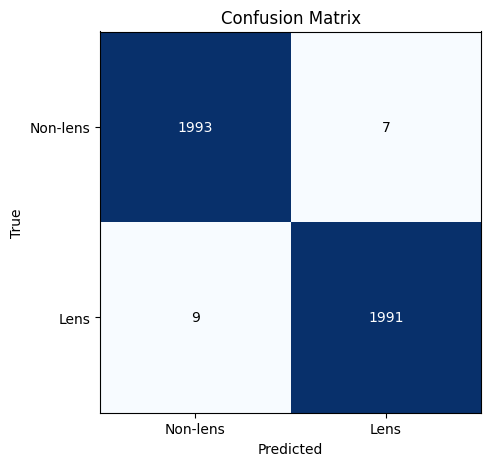

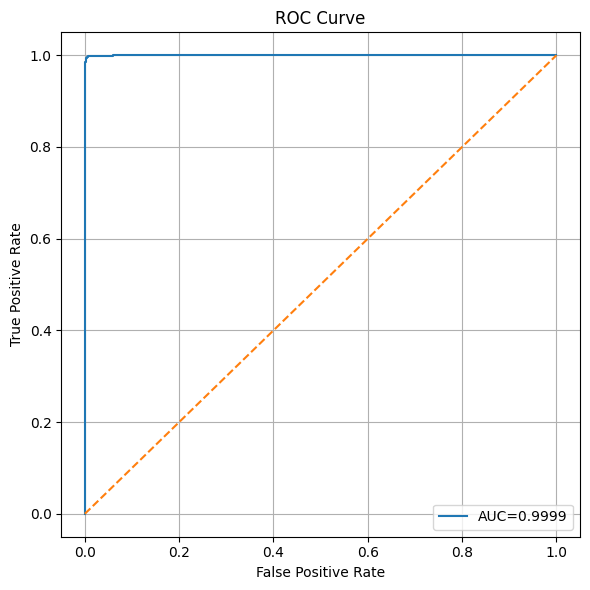

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    f1_score, precision_score, recall_score, accuracy_score
)

# ROC-based threshold (Youden J)
fpr, tpr, thr = roc_curve(all_labels, all_probs)
best_t = thr[np.argmax(tpr - fpr)]
preds = (all_probs >= best_t).astype(int)

acc = accuracy_score(all_labels, preds)
prec = precision_score(all_labels, preds, zero_division=0)
rec = recall_score(all_labels, preds)
f1 = f1_score(all_labels, preds)

try:
    auc = roc_auc_score(all_labels, all_probs)
except ValueError:
    auc = float("nan")

print(f"Best threshold t*: {best_t:.4f}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1:        {f1:.4f}")
print(f"AUC:       {auc:.4f}\n")

cm = confusion_matrix(all_labels, preds)
print("Confusion Matrix:\n", cm, "\n")

print("Classification Report:\n")
print(classification_report(all_labels, preds, digits=4))

# Plot confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0,1], ["Non-lens", "Lens"])
plt.yticks([0,1], ["Non-lens", "Lens"])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center", color="white" if v > cm.max()/2 else "black")
plt.tight_layout()
plt.show()

# Plot ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Radius MAE:  0.0536
Radius RMSE: 0.0813
Radius R^2:  0.9136
Residual mean: -0.0150 | std: 0.0799


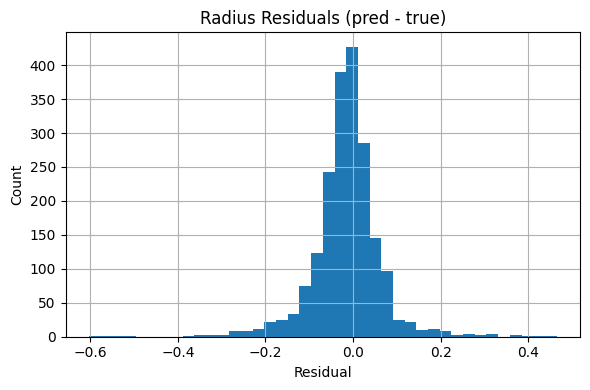

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

if len(all_r_true_phys) == 0:
    print("No y=1 samples found for radius evaluation.")
else:
    mae  = mean_absolute_error(all_r_true_phys, all_r_pred_phys)
    rmse = np.sqrt(mean_squared_error(all_r_true_phys, all_r_pred_phys))
    r2   = r2_score(all_r_true_phys, all_r_pred_phys)

    resid = all_r_pred_phys - all_r_true_phys

    print(f"Radius MAE:  {mae:.4f}")
    print(f"Radius RMSE: {rmse:.4f}")
    print(f"Radius R^2:  {r2:.4f}")
    print(f"Residual mean: {resid.mean():.4f} | std: {resid.std():.4f}")

    # Residual histogram
    plt.figure(figsize=(6,4))
    plt.hist(resid, bins=40)
    plt.title("Radius Residuals (pred - true)")
    plt.xlabel("Residual")
    plt.ylabel("Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

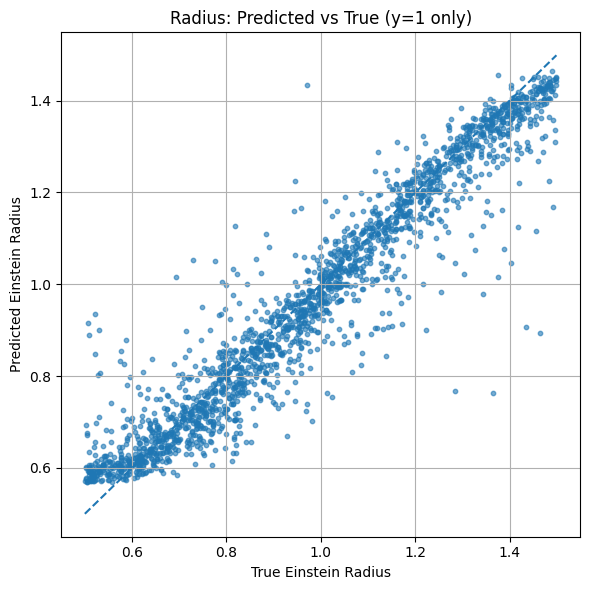

In [21]:
if len(all_r_true_phys) == 0:
    print("No y=1 samples found for radius evaluation.")
else:
    mn = min(all_r_true_phys.min(), all_r_pred_phys.min())
    mx = max(all_r_true_phys.max(), all_r_pred_phys.max())

    plt.figure(figsize=(6,6))
    plt.scatter(all_r_true_phys, all_r_pred_phys, s=10, alpha=0.6)
    plt.plot([mn, mx], [mn, mx], linestyle="--")  # y=x line
    plt.xlabel("True Einstein Radius")
    plt.ylabel("Predicted Einstein Radius")
    plt.title("Radius: Predicted vs True (y=1 only)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [22]:
import numpy as np

r_true = np.array(all_r_true_phys)
r_pred = np.array(all_r_pred_phys)

eps = 1e-8
rel_err = (r_true - r_pred) / (np.abs(r_true) + eps)

print("Relative error stats:")
print(f"  mean: {rel_err.mean():.4f}")
print(f"  std : {rel_err.std():.4f}")
print(f"  min : {rel_err.min():.4f}")
print(f"  max : {rel_err.max():.4f}")

# optional: percent form
rel_err_pct = 100.0 * rel_err

Relative error stats:
  mean: 0.0060
  std : 0.0957
  min : -0.8102
  max : 0.4415


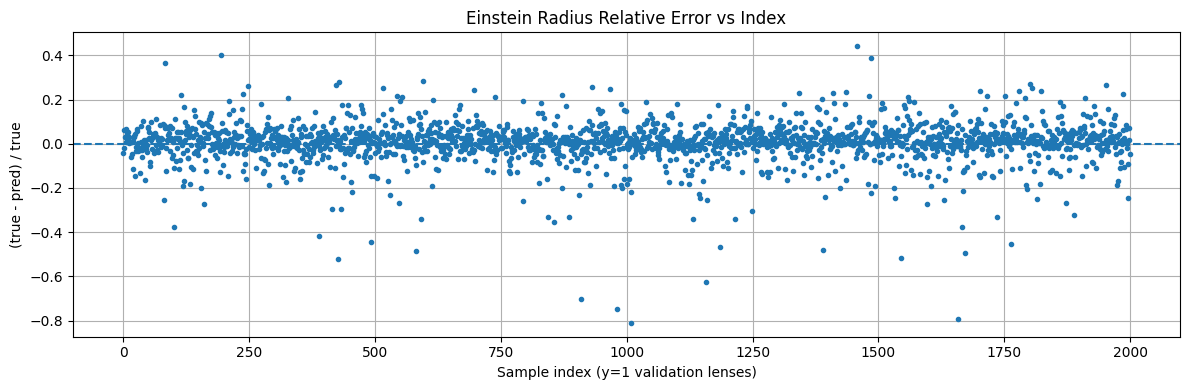

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(rel_err, marker='.', linestyle='None')  # scatter-like
plt.axhline(0.0, linestyle='--')
plt.xlabel("Sample index (y=1 validation lenses)")
plt.ylabel("(true - pred) / true")
plt.title("Einstein Radius Relative Error vs Index")
plt.grid(True)
plt.tight_layout()
plt.show()